# LSTM 302
Start with LSTM 201 and modify it to use our updated code infrastructure.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='LSTM302'   
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=16
DROP=0.25
ACT="tanh"

Mounted at /content/drive/


In [2]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    print("COMPILE...")
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    # #NOTE learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    rnn1_layer =   keras.layers.LSTM(NEURONS, return_sequences=True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP) 
    rnn2_layer =  keras.layers.LSTM(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) 
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    mlp.add(dense2_layer)
    mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

Partition sequences

In [5]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Cross validation

In [6]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [7]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
#print ("Data prep")
#X_train=tools.make_frequencies(K,X_train)

Load data from files.
Ready: train_set
Data reshape


In [8]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1040      
_________________________________________________________________
lstm (LSTM)                  (None, None, 16)          2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_____________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 42s 72ms/step - loss: 0.6392 - accuracy: 0.6512 - val_loss: 0.6239 - val_accuracy: 0.6636


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 2/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6223 - accuracy: 0.6673 - val_loss: 0.6153 - val_accuracy: 0.6698


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 3/200
453/453 [==============================] - 30s 67ms/step - loss: 0.6228 - accuracy: 0.6655 - val_loss: 0.5991 - val_accuracy: 0.6840


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 4/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6061 - accuracy: 0.6805 - val_loss: 0.6706 - val_accuracy: 0.6580
Epoch 5/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6395 - accuracy: 0.6485 - val_loss: 0.6025 - val_accuracy: 0.6772
Epoch 6/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6122 - accuracy: 0.6717 - val_loss: 0.6003 - val_accuracy: 0.6859


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 7/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6075 - accuracy: 0.6804 - val_loss: 0.5987 - val_accuracy: 0.6946


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 8/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6126 - accuracy: 0.6842 - val_loss: 0.5918 - val_accuracy: 0.7089


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 9/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6024 - accuracy: 0.6954 - val_loss: 0.5918 - val_accuracy: 0.7033
Epoch 10/200
453/453 [==============================] - 31s 69ms/step - loss: 0.6078 - accuracy: 0.6895 - val_loss: 0.6338 - val_accuracy: 0.6549
Epoch 11/200
453/453 [==============================] - 31s 67ms/step - loss: 0.6289 - accuracy: 0.6525 - val_loss: 0.5990 - val_accuracy: 0.6797
Epoch 12/200
453/453 [==============================] - 31s 69ms/step - loss: 0.6127 - accuracy: 0.6753 - val_loss: 0.6055 - val_accuracy: 0.6760
Epoch 13/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6189 - accuracy: 0.6544 - val_loss: 0.6022 - val_accuracy: 0.6828
Epoch 14/200
453/453 [==============================] - 31s 69ms/step - loss: 0.6095 - accuracy: 0.6722 - val_loss: 0.5950 - val_accuracy: 0.6977
Epoch 15/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6096 - accuracy: 0.6843 - val_loss: 0.6188 - 

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 25/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6330 - accuracy: 0.6524 - val_loss: 0.6154 - val_accuracy: 0.6760
Epoch 26/200
453/453 [==============================] - 31s 68ms/step - loss: 0.6236 - accuracy: 0.6594 - val_loss: 0.6429 - val_accuracy: 0.6530
Epoch 27/200
453/453 [==============================] - 31s 69ms/step - loss: 0.6336 - accuracy: 0.6510 - val_loss: 0.6111 - val_accuracy: 0.6791
Epoch 28/200
453/453 [==============================] - 31s 69ms/step - loss: 0.6233 - accuracy: 0.6605 - val_loss: 0.5868 - val_accuracy: 0.7101
Epoch 29/200
453/453 [==============================] - 32s 71ms/step - loss: 0.5844 - accuracy: 0.7176 - val_loss: 0.5130 - val_accuracy: 0.7554


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 30/200
453/453 [==============================] - 31s 69ms/step - loss: 0.5100 - accuracy: 0.7656 - val_loss: 0.4364 - val_accuracy: 0.7976


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 31/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4539 - accuracy: 0.7970 - val_loss: 0.4193 - val_accuracy: 0.8156


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 32/200
453/453 [==============================] - 32s 71ms/step - loss: 0.4456 - accuracy: 0.7971 - val_loss: 0.4067 - val_accuracy: 0.8200


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 33/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4385 - accuracy: 0.8046 - val_loss: 0.3986 - val_accuracy: 0.8237


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 34/200
453/453 [==============================] - 33s 72ms/step - loss: 0.4354 - accuracy: 0.8058 - val_loss: 0.4006 - val_accuracy: 0.8206
Epoch 35/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4123 - accuracy: 0.8201 - val_loss: 0.4488 - val_accuracy: 0.7945
Epoch 36/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4303 - accuracy: 0.8073 - val_loss: 0.3843 - val_accuracy: 0.8262


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 37/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4116 - accuracy: 0.8183 - val_loss: 0.3889 - val_accuracy: 0.8256
Epoch 38/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4088 - accuracy: 0.8214 - val_loss: 0.3779 - val_accuracy: 0.8318


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 39/200
453/453 [==============================] - 32s 71ms/step - loss: 0.4024 - accuracy: 0.8248 - val_loss: 0.3763 - val_accuracy: 0.8312
Epoch 40/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4179 - accuracy: 0.8152 - val_loss: 0.3814 - val_accuracy: 0.8343


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 41/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4053 - accuracy: 0.8250 - val_loss: 0.3753 - val_accuracy: 0.8318
Epoch 42/200
453/453 [==============================] - 32s 71ms/step - loss: 0.4046 - accuracy: 0.8270 - val_loss: 0.3733 - val_accuracy: 0.8256
Epoch 43/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4122 - accuracy: 0.8196 - val_loss: 0.3709 - val_accuracy: 0.8343
Epoch 44/200
453/453 [==============================] - 33s 72ms/step - loss: 0.4124 - accuracy: 0.8203 - val_loss: 0.4074 - val_accuracy: 0.8194
Epoch 45/200
453/453 [==============================] - 32s 71ms/step - loss: 0.4091 - accuracy: 0.8205 - val_loss: 0.3739 - val_accuracy: 0.8299
Epoch 46/200
453/453 [==============================] - 32s 71ms/step - loss: 0.4093 - accuracy: 0.8208 - val_loss: 0.3808 - val_accuracy: 0.8318
Epoch 47/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3957 - accuracy: 0.8291 - val_loss: 0.3676 -

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 48/200
453/453 [==============================] - 32s 72ms/step - loss: 0.3997 - accuracy: 0.8300 - val_loss: 0.3924 - val_accuracy: 0.8293
Epoch 49/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4023 - accuracy: 0.8215 - val_loss: 0.3659 - val_accuracy: 0.8386


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 50/200
453/453 [==============================] - 32s 70ms/step - loss: 0.3936 - accuracy: 0.8282 - val_loss: 0.3835 - val_accuracy: 0.8343
Epoch 51/200
453/453 [==============================] - 32s 70ms/step - loss: 0.3963 - accuracy: 0.8260 - val_loss: 0.3595 - val_accuracy: 0.8399


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 52/200
453/453 [==============================] - 32s 72ms/step - loss: 0.3932 - accuracy: 0.8286 - val_loss: 0.3608 - val_accuracy: 0.8399
Epoch 53/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3887 - accuracy: 0.8289 - val_loss: 0.3599 - val_accuracy: 0.8423


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 54/200
453/453 [==============================] - 32s 70ms/step - loss: 0.3844 - accuracy: 0.8330 - val_loss: 0.3513 - val_accuracy: 0.8492


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 55/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3899 - accuracy: 0.8302 - val_loss: 0.3671 - val_accuracy: 0.8423
Epoch 56/200
453/453 [==============================] - 32s 70ms/step - loss: 0.3813 - accuracy: 0.8372 - val_loss: 0.3526 - val_accuracy: 0.8473
Epoch 57/200
453/453 [==============================] - 32s 70ms/step - loss: 0.3818 - accuracy: 0.8347 - val_loss: 0.3460 - val_accuracy: 0.8510


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 58/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3775 - accuracy: 0.8391 - val_loss: 0.3863 - val_accuracy: 0.8287
Epoch 59/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3891 - accuracy: 0.8311 - val_loss: 0.3400 - val_accuracy: 0.8510
Epoch 60/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3800 - accuracy: 0.8348 - val_loss: 0.6016 - val_accuracy: 0.6809
Epoch 61/200
453/453 [==============================] - 33s 72ms/step - loss: 0.4720 - accuracy: 0.7786 - val_loss: 0.4616 - val_accuracy: 0.8020
Epoch 62/200
453/453 [==============================] - 32s 70ms/step - loss: 0.4087 - accuracy: 0.8238 - val_loss: 0.3526 - val_accuracy: 0.8485
Epoch 63/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3872 - accuracy: 0.8281 - val_loss: 0.3507 - val_accuracy: 0.8479
Epoch 64/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3834 - accuracy: 0.8359 - val_loss: 0.3514 -

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 68/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3774 - accuracy: 0.8397 - val_loss: 0.3325 - val_accuracy: 0.8541
Epoch 69/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3636 - accuracy: 0.8463 - val_loss: 0.3301 - val_accuracy: 0.8603


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 70/200
453/453 [==============================] - 32s 70ms/step - loss: 0.3709 - accuracy: 0.8397 - val_loss: 0.3776 - val_accuracy: 0.8417
Epoch 71/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3730 - accuracy: 0.8395 - val_loss: 0.3285 - val_accuracy: 0.8572
Epoch 72/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3646 - accuracy: 0.8414 - val_loss: 0.3277 - val_accuracy: 0.8591
Epoch 73/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3632 - accuracy: 0.8487 - val_loss: 0.3374 - val_accuracy: 0.8560
Epoch 74/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3680 - accuracy: 0.8448 - val_loss: 0.3324 - val_accuracy: 0.8579
Epoch 75/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3609 - accuracy: 0.8462 - val_loss: 0.3251 - val_accuracy: 0.8610


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 76/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3607 - accuracy: 0.8465 - val_loss: 0.3298 - val_accuracy: 0.8572
Epoch 77/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3560 - accuracy: 0.8473 - val_loss: 0.3232 - val_accuracy: 0.8634


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 78/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3571 - accuracy: 0.8490 - val_loss: 0.3188 - val_accuracy: 0.8653


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 79/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3745 - accuracy: 0.8391 - val_loss: 0.3328 - val_accuracy: 0.8560
Epoch 80/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3604 - accuracy: 0.8465 - val_loss: 0.3633 - val_accuracy: 0.8442
Epoch 81/200
453/453 [==============================] - 32s 72ms/step - loss: 0.3563 - accuracy: 0.8513 - val_loss: 0.3490 - val_accuracy: 0.8492
Epoch 82/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3539 - accuracy: 0.8525 - val_loss: 0.3229 - val_accuracy: 0.8622
Epoch 83/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3466 - accuracy: 0.8552 - val_loss: 0.3161 - val_accuracy: 0.8665


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 84/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3538 - accuracy: 0.8490 - val_loss: 0.3194 - val_accuracy: 0.8597
Epoch 85/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3443 - accuracy: 0.8543 - val_loss: 0.3162 - val_accuracy: 0.8647
Epoch 86/200
453/453 [==============================] - 33s 74ms/step - loss: 0.3552 - accuracy: 0.8499 - val_loss: 0.3105 - val_accuracy: 0.8696


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 87/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3395 - accuracy: 0.8584 - val_loss: 0.3162 - val_accuracy: 0.8641
Epoch 88/200
453/453 [==============================] - 32s 72ms/step - loss: 0.3426 - accuracy: 0.8569 - val_loss: 0.3091 - val_accuracy: 0.8672
Epoch 89/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3451 - accuracy: 0.8556 - val_loss: 0.3306 - val_accuracy: 0.8560
Epoch 90/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3413 - accuracy: 0.8526 - val_loss: 0.3484 - val_accuracy: 0.8492
Epoch 91/200
453/453 [==============================] - 33s 74ms/step - loss: 0.3327 - accuracy: 0.8644 - val_loss: 0.3409 - val_accuracy: 0.8523
Epoch 92/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3449 - accuracy: 0.8542 - val_loss: 0.3191 - val_accuracy: 0.8616
Epoch 93/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3316 - accuracy: 0.8641 - val_loss: 0.3229 -

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 109/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3163 - accuracy: 0.8714 - val_loss: 0.3323 - val_accuracy: 0.8616
Epoch 110/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3190 - accuracy: 0.8678 - val_loss: 0.3152 - val_accuracy: 0.8709
Epoch 111/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3001 - accuracy: 0.8796 - val_loss: 0.3056 - val_accuracy: 0.8678
Epoch 112/200
453/453 [==============================] - 32s 71ms/step - loss: 0.3204 - accuracy: 0.8670 - val_loss: 0.3209 - val_accuracy: 0.8690
Epoch 113/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3066 - accuracy: 0.8778 - val_loss: 0.3122 - val_accuracy: 0.8647
Epoch 114/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3118 - accuracy: 0.8745 - val_loss: 0.3152 - val_accuracy: 0.8628
Epoch 115/200
453/453 [==============================] - 32s 72ms/step - loss: 0.3169 - accuracy: 0.8715 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 117/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3026 - accuracy: 0.8737 - val_loss: 0.3155 - val_accuracy: 0.8665
Epoch 118/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3077 - accuracy: 0.8725 - val_loss: 0.3125 - val_accuracy: 0.8665
Epoch 119/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3129 - accuracy: 0.8738 - val_loss: 0.3033 - val_accuracy: 0.8709
Epoch 120/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3038 - accuracy: 0.8794 - val_loss: 0.3507 - val_accuracy: 0.8634
Epoch 121/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3078 - accuracy: 0.8738 - val_loss: 0.3083 - val_accuracy: 0.8740
Epoch 122/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3077 - accuracy: 0.8749 - val_loss: 0.3105 - val_accuracy: 0.8665
Epoch 123/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3051 - accuracy: 0.8769 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 126/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3102 - accuracy: 0.8748 - val_loss: 0.3288 - val_accuracy: 0.8653
Epoch 127/200
453/453 [==============================] - 33s 73ms/step - loss: 0.2959 - accuracy: 0.8800 - val_loss: 0.3024 - val_accuracy: 0.8703
Epoch 128/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3002 - accuracy: 0.8784 - val_loss: 0.3432 - val_accuracy: 0.8622
Epoch 129/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3128 - accuracy: 0.8684 - val_loss: 0.3066 - val_accuracy: 0.8746
Epoch 130/200
453/453 [==============================] - 32s 72ms/step - loss: 0.2999 - accuracy: 0.8771 - val_loss: 0.3073 - val_accuracy: 0.8752


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 131/200
453/453 [==============================] - 34s 75ms/step - loss: 0.2942 - accuracy: 0.8771 - val_loss: 0.3150 - val_accuracy: 0.8690
Epoch 132/200
453/453 [==============================] - 33s 72ms/step - loss: 0.2908 - accuracy: 0.8833 - val_loss: 0.3493 - val_accuracy: 0.8579
Epoch 133/200
453/453 [==============================] - 33s 73ms/step - loss: 0.2987 - accuracy: 0.8803 - val_loss: 0.3257 - val_accuracy: 0.8715
Epoch 134/200
453/453 [==============================] - 32s 72ms/step - loss: 0.2938 - accuracy: 0.8780 - val_loss: 0.3052 - val_accuracy: 0.8808


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 135/200
453/453 [==============================] - 33s 72ms/step - loss: 0.3032 - accuracy: 0.8742 - val_loss: 0.3136 - val_accuracy: 0.8665
Epoch 136/200
453/453 [==============================] - 33s 73ms/step - loss: 0.3037 - accuracy: 0.8704 - val_loss: 0.3567 - val_accuracy: 0.8634
Epoch 137/200
453/453 [==============================] - 32s 72ms/step - loss: 0.3007 - accuracy: 0.8784 - val_loss: 0.3106 - val_accuracy: 0.8690
Epoch 138/200
453/453 [==============================] - 32s 71ms/step - loss: 0.2928 - accuracy: 0.8803 - val_loss: 0.3127 - val_accuracy: 0.8752
Epoch 139/200
453/453 [==============================] - 33s 72ms/step - loss: 0.2936 - accuracy: 0.8821 - val_loss: 0.3212 - val_accuracy: 0.8721
Epoch 140/200
453/453 [==============================] - 33s 73ms/step - loss: 0.2914 - accuracy: 0.8816 - val_loss: 0.3588 - val_accuracy: 0.8579
Epoch 141/200
453/453 [==============================] - 32s 72ms/step - loss: 0.2791 - accuracy: 0.8889 - val_loss: 0

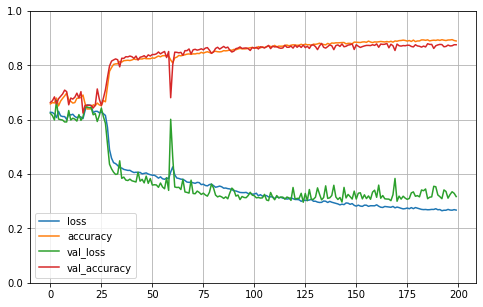

accuracy: 88.08%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 41s 76ms/step - loss: 0.6416 - accuracy: 0.6490 - val_loss: 0.6435 - val_accuracy: 0.6449


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


Epoch 2/200
453/453 [==============================] - 33s 72ms/step - loss: 0.6279 - accuracy: 0.6518 - val_loss: 0.6095 - val_accuracy: 0.6735


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


Epoch 3/200
453/453 [==============================] - 32s 71ms/step - loss: 0.6035 - accuracy: 0.6801 - val_loss: 0.6081 - val_accuracy: 0.6741


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


Epoch 4/200
453/453 [==============================] - 33s 73ms/step - loss: 0.6020 - accuracy: 0.6875 - val_loss: 0.7401 - val_accuracy: 0.5326
Epoch 5/200
453/453 [==============================] - 32s 72ms/step - loss: 0.6192 - accuracy: 0.6676 - val_loss: 0.6466 - val_accuracy: 0.6449
Epoch 6/200
453/453 [==============================] - 33s 73ms/step - loss: 0.6222 - accuracy: 0.6506 - val_loss: 0.6022 - val_accuracy: 0.6791


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


Epoch 7/200
453/453 [==============================] - 33s 73ms/step - loss: 0.6002 - accuracy: 0.6810 - val_loss: 0.6028 - val_accuracy: 0.6927


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


Epoch 8/200
453/453 [==============================] - 33s 73ms/step - loss: 0.5939 - accuracy: 0.7018 - val_loss: 0.6152 - val_accuracy: 0.6691
Epoch 9/200
453/453 [==============================] - 33s 73ms/step - loss: 0.6176 - accuracy: 0.6733 - val_loss: 0.6091 - val_accuracy: 0.6716
Epoch 10/200
453/453 [==============================] - 33s 73ms/step - loss: 0.6085 - accuracy: 0.6829 - val_loss: 0.5953 - val_accuracy: 0.6946


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.2.best/assets


Epoch 11/200
453/453 [==============================] - 32s 72ms/step - loss: 0.6257 - accuracy: 0.6641 - val_loss: 0.6050 - val_accuracy: 0.6654
Epoch 12/200
453/453 [==============================] - 33s 72ms/step - loss: 0.6123 - accuracy: 0.6819 - val_loss: 0.6477 - val_accuracy: 0.6449
Epoch 13/200
452/453 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6385

In [ ]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")